### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

import tensorflow as tf
from keras import Sequential, regularizers
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras_tuner import HyperModel, Hyperband

print("TensorFlow version: ", tf.__version__)
print("Number of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version:  2.19.0
Number of GPUs available:  1


In [3]:
!nvidia-smi
# !kill -9 <PID>

Wed Apr  9 17:56:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40                     Off |   00000000:17:00.0 Off |                    0 |
| N/A   39C    P0             83W /  300W |     867MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Data Preprocessing

In [4]:
spike = 2
wind_cols = ['uSq','Z2','Z4']
scaled_wind_cols = ['scaled_' + col for col in wind_cols]

# Load datasets
df_buoy_04_13 = pd.read_csv('Data_Buoy_2004_2013.csv')
df_stn_04_13 = pd.read_csv('Data_Sikorsky_2004_2013.csv')
df_stn_73_04 = pd.read_csv('Data_Sikorsky_1973_2004.csv')

# Rename columns
df_buoy_04_13 = df_buoy_04_13.rename(columns={'SWHft':'H'})
df_stn_04_13 = df_stn_04_13.rename(columns={'Fetch':'Z3'})
df_stn_73_04 = df_stn_73_04.rename(columns={'Fetch':'Z3'})

# Add transformed wind speed (u)
df_stn_04_13['u'] = df_stn_04_13['rWSPD_T'].shift(-1).ffill()
df_stn_73_04['u'] = df_stn_73_04['rWSPD_T'].shift(-1).ffill()

# Add squared terms (u^2)
df_stn_04_13['uSq'] = df_stn_04_13['u']**2
df_stn_73_04['uSq'] = df_stn_73_04['u']**2

# Add interaction terms (Z2, Z4)
df_stn_04_13['Z2'] = np.sqrt(df_stn_04_13['Z3']) * df_stn_04_13['u']
df_stn_73_04['Z2'] = np.sqrt(df_stn_73_04['Z3']) * df_stn_73_04['u']
df_stn_04_13['Z4'] = (df_stn_04_13['Z3']**1.5) / df_stn_04_13['u']
df_stn_73_04['Z4'] = (df_stn_73_04['Z3']**1.5) / df_stn_73_04['u']

# Data aggregation
df1 = pd.concat([df_buoy_04_13[['TimeStamp_1','H']], df_stn_04_13[wind_cols]], axis=1)
df2 = df_stn_73_04[['TimeStamp_1'] + wind_cols].copy()

# Set the timestamp column as the index
df1['TimeStamp_1'] = pd.to_datetime(df1['TimeStamp_1'], format='mixed')
df2['TimeStamp_1'] = pd.to_datetime(df2['TimeStamp_1'], format='mixed')
df1.set_index('TimeStamp_1', inplace=True)
df2.set_index('TimeStamp_1', inplace=True)

# Train-Test split
# df_train: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2008-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# df_test: [2007-11-01 00:00:00 ~ 2008-10-31 23:00:00]
split1 = pd.to_datetime('2007-10-31 23:59:00')
split2 = pd.to_datetime('2008-10-31 23:59:00')
df_train = df1[(df1.index < split1) | (df1.index > split2)]
df_test = df1[(df1.index > split1) & (df1.index < split2)]

# Data normalization
scaled_wave, scaled_wind = MinMaxScaler(), MinMaxScaler()
df_train, df_test = df_train.copy(), df_test.copy()

# Normalize wave in the first dataset
df_train.loc[:, 'scaled_H'] = scaled_wave.fit_transform(df_train[['H']])
df_test.loc[:, 'scaled_H'] = scaled_wave.transform(df_test[['H']])
mask = scaled_wave.transform(pd.DataFrame({'H': [spike]}))[0, 0]

# Normalize wind in both datasets
df_train.loc[:, scaled_wind_cols] = scaled_wind.fit_transform(df_train[wind_cols])
df_test.loc[:, scaled_wind_cols] = scaled_wind.transform(df_test[wind_cols])
df2.loc[:, scaled_wind_cols] = scaled_wind.transform(df2[wind_cols])

### Data Preparation: Train-Test-Validation Split

In [5]:
time_step = 6
features = ['scaled_H'] + scaled_wind_cols

def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step+1), 1:]) # (Past + Current) hours wind features
        y.append(data[i+time_step, 0])        # Current hour wave height
    return np.array(X), np.array(y)

# Training set: [2004-11-01 00:00:00 ~ 2007-10-31 23:00:00, 2009-11-01 00:00:00 ~ 2013-10-31 23:00:00]
# Validation set: [2008-11-01 00:00:00 ~ 2009-10-31 23:00:00]
split3 = pd.to_datetime('2009-10-31 23:59:00')
df_train1 = df_train[df_train.index < split1]
df_train2 = df_train[df_train.index > split3]
df_val = df_train[(df_train.index > split2) & (df_train.index < split3)]

X_train1, y_train1 = create_sequences(df_train1[features].values, time_step)
X_train2, y_train2 = create_sequences(df_train2[features].values, time_step)
X_train, y_train = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((y_train1, y_train2), axis=0)
X_val, y_val = create_sequences(df_val[features].values, time_step)
X_test, y_test = create_sequences(df_test[features].values, time_step)

X_train, y_train = X_train[y_train <= mask], y_train[y_train <= mask]
X_val, y_val = X_val[y_val <= mask], y_val[y_val <= mask]
X_test, y_test = X_test[y_test <= mask], y_test[y_test <= mask]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48181, 7, 3)
(6409, 7, 3)
(6852, 7, 3)


### Model Selection and Implementation

In [ ]:
epochs = 50
batch_size = 64
model_file = 'model_reg0.keras'

# Model architecture
def create_model(X_train):
    model = Sequential([
        # Input layer with shape: (samples, time_steps, features)
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        
        # LSTM layers
        LSTM(128, activation='tanh', kernel_regularizer=regularizers.l2(0.01), dropout=0.2, return_sequences=False),
        
        # Output layer
        Dense(1),
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])
    
    return model

# Train and save the model (architecture + weights)
model = create_model(X_train)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])
model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Hyperparameters Tuning

- **Time steps**: 6, 12
- **Batch size**: 16, 32
- **# of LSTM layers**: 1, 2
- **# of LSTM units**: 32, 64, 128
- **Dropout rate**: 0.2
- **Activation**: 'tanh' (might work better for LSTM layers)
- **Learning rate**: logarithmic sampling of $10^{-4}$ ~ $10^{-2}$

In [6]:
epochs = 50
batch_size = 64

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        
        # Input layer with shape: (samples, time_steps, features)
        model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
        
        # Tunable LSTM layers and units
        num_layers = hp.Int('layers', min_value=1, max_value=2, step=1)
        for i in range(num_layers):
            model.add(LSTM(
                hp.Choice(f'units_{i}', values=[32, 64, 128]),
                activation = hp.Choice(f'activation_{i}', values=['tanh']),
                kernel_regularizer = regularizers.l2(0.01),
                dropout = hp.Choice(f'dropout_{i}', values=[0.2]),
                return_sequences = True if i < num_layers-1 else False))
        
        # Output layer
        model.add(Dense(1))
        
        # Compile the model
        model.compile(
            optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
            loss = 'mse',
            metrics = ['mse'],
        )
        
        return model

# Search space setup
tuner = Hyperband(
    LSTMHyperModel(),
    objective = 'val_loss',
    max_epochs = 30,
    factor = 3,
    directory = 'hp_tuning',
    project_name = 'model_reg0',
)

# Hyperparameter tuning
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tuner.search(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es])

Reloading Tuner from hp_tuning/model_reg0/tuner0.json


In [7]:
# Best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)
print()

# Best model
best_model = tuner.hypermodel.build(best_hp)
best_model.compile(optimizer=Adam(learning_rate=best_hp.values['learning_rate']), loss='mse', metrics=['mse'])
print(best_model.summary())

{'layers': 1, 'units_0': 128, 'activation_0': 'tanh', 'dropout_0': 0.2, 'learning_rate': 0.0002842408412037808, 'units_1': 32, 'activation_1': 'tanh', 'dropout_1': 0.2, 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0081'}



I0000 00:00:1744235907.996982 3265881 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43500 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:ca:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,713 (264.50 KB)

 Trainable params: 67,713 (264.50 KB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1744235918.161034 3266277 cuda_dnn.cc:529] Loaded cuDNN version 90300


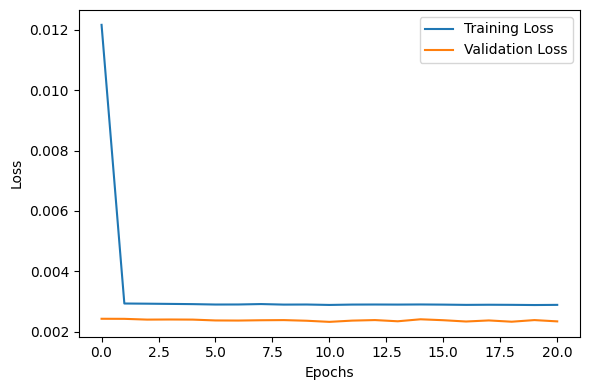

In [8]:
model_file = 'best_model_reg0.keras'

# Train and save the model (architecture + weights)
history = best_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es], verbose=0)
best_model.save(model_file)

# Plot the training & validation loss over epochs
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

In [9]:
# Load the saved model
model = load_model(model_file)

# Training error
y_pred1 = model.predict(X_train, verbose=0)
y_pred1_raw = scaled_wave.inverse_transform(y_pred1)
y_true1 = pd.concat([df_train1['H'][time_step:], df_train2['H'][time_step:]], axis=0)
y_true1 = y_true1[y_true1 <= spike]
print(f'Training RMSE: {np.sqrt(mean_squared_error(y_true1, y_pred1_raw)):.3f}')

# Validation error
y_pred2 = model.predict(X_val, verbose=0)
y_pred2_raw = scaled_wave.inverse_transform(y_pred2)
y_true2 = df_val['H'][time_step:]
y_true2 = y_true2[y_true2 <= spike]
print(f'Validation RMSE: {np.sqrt(mean_squared_error(y_true2, y_pred2_raw)):.3f}')

# Test error
y_pred3 = model.predict(X_test, verbose=0)
y_pred3_raw = scaled_wave.inverse_transform(y_pred3)
y_true3 = df_test['H'][time_step:]
y_true3 = y_true3[y_true3 <= spike]
print(f'Test RMSE: {np.sqrt(mean_squared_error(y_true3, y_pred3_raw)):.3f}')

Training RMSE: 0.538
Validation RMSE: 0.488
Test RMSE: 0.496


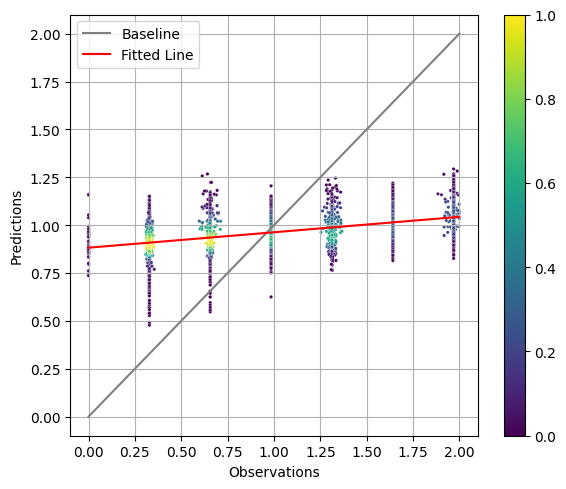

In [10]:
def pred_vs_obs(y_true, y_pred):
    y_pred = y_pred.flatten()
    fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot([0, spike], [0, spike], color='grey', label='Baseline')
    ax.plot(np.unique(y_true), np.poly1d(np.polyfit(y_true,y_pred,1))(np.unique(y_true)), color='r', label='Fitted Line')
    ax.set(xlabel='Observations', ylabel='Predictions')
    ax.legend()
    ax.grid()
    
    kernel = stats.gaussian_kde(np.vstack([y_true, y_pred]))(np.vstack([y_true, y_pred]))
    sns.scatterplot(x=y_true, y=y_pred, c=kernel, s=6, cmap='viridis', ax=ax)
    fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
    
    plt.tight_layout()
    plt.show()

pred_vs_obs(y_true3, y_pred3_raw)

### Model Output

In [11]:
# Create sequences for the full dataset
df1 = pd.concat([df_train[df_train.index < split1], df_test, df_train[df_train.index > split2]], axis=0)
X, _ = create_sequences(df1[features].values, time_step)

# Add predicted wave heights
df1['H_pred0'] = 0.0
df1.loc[df1.index[time_step:], 'H_pred0'] = model.predict(X, verbose=0).flatten()

# Save to CSV
df1.to_csv('Data_2004_2013.csv')
df2.to_csv('Data_1973_2004.csv')

df1.head(10)

,H,uSq,Z2,Z4,scaled_H,scaled_uSq,scaled_Z2,scaled_Z4,H_pred0
TimeStamp_1,,,,,,,,,
2004-11-01 00:00:00,3.249133,19.225945,556.247086,465615.964363,0.319463,0.042443,0.101141,0.021635,0.000000
2004-11-01 01:00:00,3.249133,47.299731,872.475497,296853.635864,0.319463,0.111609,0.181946,0.012009,0.000000
2004-11-01 02:00:00,1.960359,43.096993,832.812792,310991.288972,0.192748,0.101255,0.171811,0.012816,0.000000
2004-11-01 03:00:00,2.001249,28.241040,674.161969,384177.000917,0.196768,0.064654,0.131272,0.016990,0.000000
2004-11-01 04:00:00,3.254957,35.278017,753.487381,343731.733585,0.320036,0.081991,0.151541,0.014683,0.000000
2004-11-01 05:00:00,3.298333,33.337921,732.475598,353592.016416,0.324301,0.077211,0.146172,0.015245,0.000000
2004-11-01 06:00:00,0.298153,67.513173,1042.361020,248471.996288,0.029315,0.161410,0.225356,0.009250,0.101553
2004-11-01 07:00:00,0.329992,43.711596,838.730115,308797.214744,0.032446,0.102769,0.173323,0.012690,0.103416
2004-11-01 08:00:00,0.307853,55.203975,942.560154,274780.895794,0.030269,0.131084,0.199855,0.010750,0.103958
